# Separate the 2 sec trial in small windows and then separate on train and test

Correct approach (split then window):
 - Train trials after windowing: 3200
 - Test trials after windowing: 800
 - Test accuracy: 0.579

Incorrect approach (window then split):
 - Total trials after windowing: 4000
 - Train trials after splitting: 3200
 - Test trials after splitting: 800
 - Test accuracy: 0.570


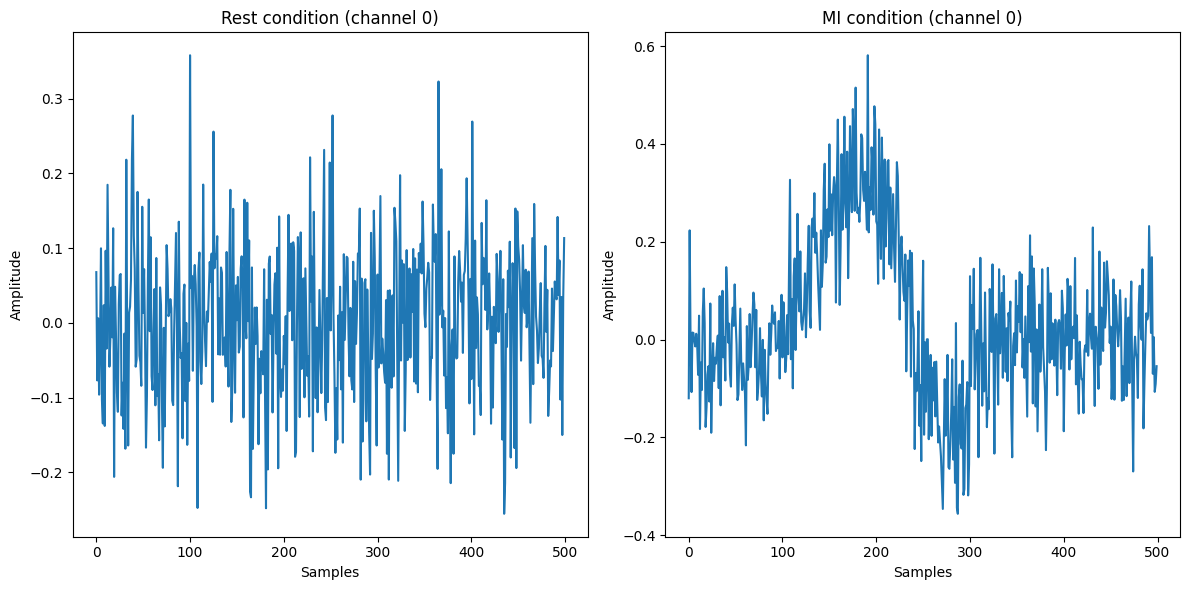

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Simulation parameters
n_channels = 8
n_trials = 200  # 100 rest, 100 MI
trial_duration = 2  # seconds
sampling_rate = 250  # Hz
n_samples = trial_duration * sampling_rate  # 500 samples per trial
window_size = 0.1  # seconds for sliding window
window_step = 0.1  # seconds for sliding window step

# Generate synthetic EEG data
def generate_eeg_data(n_trials, n_samples, n_channels):
    # Rest condition: random noise with some channel-specific patterns
    rest_data = np.random.randn(n_trials//2, n_channels, n_samples) * 0.1
    for i in range(n_channels):
        rest_data[:, i, :] += np.sin(np.linspace(0, 10, n_samples)) * 0.01
    
    # Motor imagery condition: add some event-related patterns
    mi_data = np.random.randn(n_trials//2, n_channels, n_samples) * 0.1
    for i in range(n_channels):
        # Simulate ERD/ERS patterns
        mi_data[:, i, 100:300] += np.sin(np.linspace(0, 5, 200)) * 0.2
        if i < 4:  # Simulate lateralized activity for some channels
            mi_data[:, i, 150:250] += np.sin(np.linspace(0, 3, 100)) * 0.2
    
    # Combine data and create labels
    X = np.concatenate([rest_data, mi_data])
    y = np.concatenate([np.zeros(n_trials//2), np.ones(n_trials//2)])
    
    return X, y

# Apply sliding window to create more trials
def apply_sliding_window(X, y, window_size_samples, window_step_samples):
    n_trials, n_channels, n_samples = X.shape
    new_X = []
    new_y = []
    
    for trial in range(n_trials):
        for start in range(0, n_samples - window_size_samples + 1, window_step_samples):
            end = start + window_size_samples
            window = X[trial, :, start:end]
            new_X.append(window)
            new_y.append(y[trial])
    
    return np.array(new_X), np.array(new_y)

# Generate data
X, y = generate_eeg_data(n_trials, n_samples, n_channels)

# Convert to trials x features format for classification
def reshape_for_clf(X):
    return X.reshape(X.shape[0], -1)  # Flatten last two dimensions

# Approach 1: CORRECT - Split first, then window
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Apply sliding window to train and test separately
window_size_samples = int(window_size * sampling_rate)
window_step_samples = int(window_step * sampling_rate)

X_train_win, y_train_win = apply_sliding_window(
    X_train_full, y_train_full, window_size_samples, window_step_samples)
X_test_win, y_test_win = apply_sliding_window(
    X_test_full, y_test_full, window_size_samples, window_step_samples)

# Reshape for classification
X_train_1 = reshape_for_clf(X_train_win)
X_test_1 = reshape_for_clf(X_test_win)

# Approach 2: INCORRECT - Window first, then split
X_win, y_win = apply_sliding_window(X, y, window_size_samples, window_step_samples)
X_win_reshaped = reshape_for_clf(X_win)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_win_reshaped, y_win, test_size=0.2, random_state=42, stratify=y_win)

# Train and evaluate classifiers
clf = LinearDiscriminantAnalysis()

# Approach 1 results
clf.fit(X_train_1, y_train_win)
y_pred_1 = clf.predict(X_test_1)
acc1 = accuracy_score(y_test_win, y_pred_1)

# Approach 2 results
clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)
acc2 = accuracy_score(y_test_2, y_pred_2)

# Print results
print(f"Correct approach (split then window):")
print(f" - Train trials after windowing: {X_train_1.shape[0]}")
print(f" - Test trials after windowing: {X_test_1.shape[0]}")
print(f" - Test accuracy: {acc1:.3f}")

print(f"\nIncorrect approach (window then split):")
print(f" - Total trials after windowing: {X_win_reshaped.shape[0]}")
print(f" - Train trials after splitting: {X_train_2.shape[0]}")
print(f" - Test trials after splitting: {X_test_2.shape[0]}")
print(f" - Test accuracy: {acc2:.3f}")

# Plot some data samples
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Rest condition (channel 0)")
plt.plot(X_train_full[0, 0, :])
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.subplot(1, 2, 2)
plt.title("MI condition (channel 0)")
plt.plot(X_train_full[-1, 0, :])
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()